In [36]:
%matplotlib inline
from collections import defaultdict
import pymc as pm
from pymc.Matplot import plot as mcplot
import numpy as np
from matplotlib import pyplot as plt
import json
from pymongo import MongoClient
import pymongo
from bson.objectid import ObjectId
import random

## Data Structure

In [37]:
def random_limit(distribution):
    val = distribution.random()
    while val > 1 or val < 0:
        val = distribution.random()
    return val

class grader(object):
    def __init__(self, name,bias_mean,bias_tau):
        self.name = name
        self.handins = list()
        self.bias_mean = bias_mean
        self.bias_tau = bias_tau
        
    def add_handin(self, handin):
        self.handins.append(handin)
                
    def grade_handins(self):
        for handin in self.handins:
            B = pm.Normal('B_generator',self.bias_mean,self.bias_tau)
            handin.add_gradeing(self,B.random())

class handin:
    def __init__(self,title,owner,true_value):
        self.title = title
        self.owner = owner
        self.gradeings = dict()
        self.graders = list()
        self.true_val = true_value
    
    def add_grader(self,grader):
        self.graders.append(grader)
    
    def add_gradeing(self,grader,bias):
        obs = pm.Normal('obs_generator',self.true_val+bias,100)
        self.gradeings[grader.name] = random_limit(obs)
        
        
class assignment(object):
    
    def __init__(self, handins_input, graders_input):
        self.handins = dict()
        self.graders = dict()
        for handin in handins_input:
            self.handins[handin.title] = handin
        for grader in graders_input:
            self.graders[grader.name] = grader
    
    def add_handin(self, handin):
        self.handing[handin.title] = handin
        
    def add_grader(self, grader):
        self.graders[grader.title] = grader
    
    def find_ungraded_handin(self, grader):
        
        # sort the handins by the one with the least
        sorted_l = sorted(self.handins.values(),key=lambda x: len(x.graders))
        #i = int(random.uniform(0,len(sorted_l)))
        i = 0
        handin = sorted_l[i]
        while handin in grader.handins or (handin.owner.name == grader.name):
        #while(handin.owner.name == grader.name):
            i += 1
            #i = int(random.uniform(0,len(sorted_l)))
            handin = sorted_l[i]
        return handin
            
    def grade_handins(self,n_handins):
        # Distribute handins
        for i in xrange(0,n_handins):
            for grader in self.graders.itervalues():
                h = self.find_ungraded_handin(grader)
                h.add_grader(g)
                grader.add_handin(h)
                
        # grade handins
        for grader in self.graders.itervalues():
            grader.grade_handins()

## Generate Observed Data

In [38]:
T_mu = pm.Normal('T_mu_generator',0.5,25)
B_mu = pm.Normal('B_mu_generator',0,100)
B_tau = pm.Gamma('B_tau_generator',50,0.1)

handins_data = list()
graders_data = list()

for i in xrange(0,20):
    g = grader('grader_%i' % i,B_mu.random(),B_tau.random())
    t_mu = random_limit(T_mu)
    T = pm.Normal('T_generator',t_mu,100)
    h = handin('handin_%i' % i, g, random_limit(T))
    graders_data.append(g)
    handins_data.append(h)
    
assignment_data_true = assignment(handins_data,graders_data)
assignment_data_true.grade_handins(10)

In [39]:
T_mu = pm.Normal('T_mu_generator',0.5,25)
B_mu = pm.Normal('B_mu_generator',0,100)
B_tau = pm.Gamma('B_tau_generator',50,0.1)

handins_data = list()

for i in xrange(20,40):
    t_mu = random_limit(T_mu)
    T = pm.Normal('T_generator',t_mu,100)
    h = handin('handin_%i' % i, graders_data[i-20], random_limit(T))
    handins_data.append(h)
    
assignment_data_2 = assignment(handins_data,graders_data)
assignment_data_2.grade_handins(10)

In [40]:
T_mu = pm.Normal('T_mu_generator',0.5,25)
B_mu = pm.Normal('B_mu_generator',0,100)
B_tau = pm.Gamma('B_tau_generator',50,0.1)

handins_data = list()

for i in xrange(40,60):
    t_mu = random_limit(T_mu)
    T = pm.Normal('T_generator',t_mu,100)
    h = handin('handin_%i' % i, graders_data[i-60], random_limit(T))
    handins_data.append(h)
    
assignment_data_3 = assignment(handins_data,graders_data)
assignment_data_3.grade_handins(10)

## Models

In [41]:
def execute_model(model):
    mcmc = pm.MCMC(model)
    mcmc.sample(1500)
    return mcmc

In [42]:
def handin_model_1(data):
    N_H = len(data)
    
    # Bias
    T = dict()
    B = dict()
    B_mu = dict()
    B_tau = dict()
    O = list()

    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        T_mu = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T[h_id] = pm.Normal('T_%s' % str(h_id), mu=T_mu, tau=100)
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B:
                if g_id not in B_mu:
                    B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
                if g_id not in B_tau:
                    B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)
                B[g_id] = pm.Normal('B_%s' % str(g_id), mu=B_mu[g_id], tau=B_tau[g_id])
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T[h_id] + B[g_id], tau=100, observed=True, value=val))
        
            
    collection = [pm.Container(T),
                  pm.Container(O),
                  pm.Container(B)]
    
    model = pm.Model(collection)
    map_ = pm.MAP(model)
    map_.fit()
    return model

In [43]:
def handin_model_2(data):
    N_H = len(data)
    
    # Bias
    T = dict()
    B = dict()
    B_mu = dict()
    B_tau = dict()
    O = list()

    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        T_mu = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T_tau = pm.Gamma('T_tau_%s' % str(h_id),10,0.1)
        T[h_id] = pm.Normal('T_%s' % str(h_id), mu=T_mu, tau=T_tau)
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B:
                if g_id not in B_mu:
                    B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
                if g_id not in B_tau:
                    B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)
                B[g_id] = pm.Normal('B_%s' % str(g_id), mu=B_mu[g_id], tau=B_tau[g_id])
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T[h_id] + B[g_id], tau=100, observed=True, value=val))
        
            
    collection = [pm.Container(T),
                  pm.Container(O),
                  pm.Container(B)]
    
    model = pm.Model(collection)
    map_ = pm.MAP(model)
    map_.fit()
    return model

In [44]:
def handin_model_3(data):
    N_H = len(data)
    
    # Bias
    T = dict()
    B = dict()
    B_mu = dict()
    B_tau = dict()
    O = list()

    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        T_mu = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T_tau = pm.Gamma('T_tau_%s' % str(h_id),10,0.1)
        T[h_id] = pm.Normal('T_%s' % str(h_id), mu=T_mu, tau=T_tau)
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B:
                if g_id not in B_mu:
                    B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
                if g_id not in B_tau:
                    B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)
                B[g_id] = pm.Normal('B_%s' % str(g_id), mu=B_mu[g_id], tau=B_tau[g_id])
                
            O_tau = pm.Gamma('O_%(h)i_%(g)i' % {'h': h, 'g':g},10,0.1)
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T[h_id] + B[g_id], tau=O_tau, observed=True, value=val))
               
    collection = [pm.Container(T),
                  pm.Container(O),
                  pm.Container(B)]
    
    model = pm.Model(collection)
    map_ = pm.MAP(model)
    map_.fit()
    return model

In [45]:
def handin_model_4(data):
    N_H = len(data)
    
    # Bias
    T = dict()
    B = dict()
    B_mu = dict()
    O = list()

    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        T_mu = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T[h_id] = pm.Normal('T_%s' % str(h_id), mu=T_mu, tau=100)
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B:
                if g_id not in B_mu:
                    B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
                B[g_id] = pm.Normal('B_%s' % str(g_id), mu=B_mu[g_id], tau=500)         

            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T[h_id] + B[g_id], tau=100, observed=True, value=val))
           
    collection = [pm.Container(T),
                  pm.Container(O),
                  pm.Container(B)]
    
    model = pm.Model(collection)
    map_ = pm.MAP(model)
    map_.fit()
    return model

In [46]:
def handin_model_5(data):
    N_H = len(data)
    
    # Bias
    T = dict()
    B = dict()
    O = list()

    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        T_mu = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T[h_id] = pm.Normal('T_%s' % str(h_id), mu=T_mu, tau=100)
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B:
                B[g_id] = pm.Normal('B_%s' % str(g_id), mu=0, tau=500)
                
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T[h_id] + B[g_id], tau=100, observed=True, value=val))
            
    collection = [pm.Container(T),
                  pm.Container(O),
                  pm.Container(B)]
    
    model = pm.Model(collection)
    map_ = pm.MAP(model)
    map_.fit()
    return model

In [47]:
def handin_model_6(data):
    N_H = len(data)
    
    # Bias
    T = dict()
    B = dict()
    B_mu = dict()
    B_tau = dict()
    O = list()

    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        T_mu = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T[h_id] = pm.Normal('T_%s' % str(h_id), mu=T_mu, tau=100)
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B:
                if g_id not in B_mu:
                    B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
                if g_id not in B_tau:
                    B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)
                B[g_id] = pm.Normal('B_%s' % str(g_id), mu=B_mu[g_id], tau=B_tau[g_id])
                
            O_tau = pm.Gamma('O_%(h)i_%(g)i' % {'h': h, 'g':g},10,0.1)
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T[h_id] + B[g_id], tau=O_tau, observed=True, value=val))
               
    collection = [pm.Container(T),
                  pm.Container(O),
                  pm.Container(B)]
    
    model = pm.Model(collection)
    map_ = pm.MAP(model)
    map_.fit()
    return model

In [48]:
def run_3_iteration(model_,values):
    model_back = model_(values)
    mcmc_back_1 = execute_model(model_back)
    mcmc_back_2 = execute_model(model_back)
    mcmc_back_3 = execute_model(model_back)
    return [mcmc_back_1,mcmc_back_2,mcmc_back_3]

In [49]:
values = assignment_data_true.handins.values()
#values.extend(assignment_data_2.handins.values())
#values.extend(assignment_data_3.handins.values())
mcmc_1 = run_3_iteration(handin_model_1,values)

 [-----------------100%-----------------] 1500 of 1500 complete in 20.5 sec

In [50]:
values = assignment_data_true.handins.values()
#values.extend(assignment_data_2.handins.values())
#values.extend(assignment_data_3.handins.values())
mcmc_2 = run_3_iteration(handin_model_2,values)

 [-----------------100%-----------------] 1500 of 1500 complete in 22.4 sec

In [51]:
values = assignment_data_true.handins.values()
#values.extend(assignment_data_2.handins.values())
#values.extend(assignment_data_3.handins.values())
mcmc_3 = run_3_iteration(handin_model_3,values)

 [-----------------100%-----------------] 1500 of 1500 complete in 52.4 sec

In [52]:
values = assignment_data_true.handins.values()
#values.extend(assignment_data_2.handins.values())
#values.extend(assignment_data_3.handins.values())
mcmc_4 = run_3_iteration(handin_model_4,values)

 [-----------------100%-----------------] 1500 of 1500 complete in 24.3 sec

In [53]:
values = assignment_data_true.handins.values()
#values.extend(assignment_data_2.handins.values())
#values.extend(assignment_data_3.handins.values())
mcmc_5 = run_3_iteration(handin_model_5,values)

 [-----------------100%-----------------] 1500 of 1500 complete in 23.8 sec

In [54]:
values = assignment_data_true.handins.values()
#values.extend(assignment_data_2.handins.values())
#values.extend(assignment_data_3.handins.values())
mcmc_6 = run_3_iteration(handin_model_6,values)

 [-----------------100%-----------------] 1500 of 1500 complete in 44.1 sec

## Plot

In [55]:
def find_bias(assignment,mcmc,f):
    bias_abs = list()
    for g in assignment.graders.keys():
        bias_mean = f(mcmc.trace('B_%s' % str(g))[:])
        bias_abs.append((bias_mean,g))
    return bias_abs

In [56]:
def find_T(assignment,mcmc,f):
    bias = list()
    for h in assignment.handins.keys():
        bias_mean = f(mcmc.trace('T_%s' % str(h))[:])
        bias.append((bias_mean,h))
    return bias

In [57]:
def compare_to_generated(assignment_data,mcmc_handins,find,func=np.mean):
    bias_abs_1 = find(assignment_data, mcmc_handins[0], func)
    bias_abs_2 = find(assignment_data, mcmc_handins[1], func)
    bias_abs_3 = find(assignment_data, mcmc_handins[2], func)

    # Generate dict of the found values in each run for each grader
    compared = defaultdict(list)
    collected = list()
    collected = bias_abs_1[:]
    collected.extend(bias_abs_2[:])
    collected.extend(bias_abs_3[:])

    for (value, _id) in collected:
        compared[_id].append(value)
    
    sorted_list = list()
    if find.func_name == "find_bias":
        for _id, g in assignment_data.graders.iteritems():
            if func.func_name == "mean":
                sorted_list.append((_id,g.bias_mean))
            else:
                sorted_list.append((_id,g.bias_tau))
    else:
        for _id, h in assignment_data.handins.iteritems():
            sorted_list.append((_id,h.true_val))
    sorted_list.sort(key=lambda x: x[1])

    ax = plt.subplot(111)
    
    labels = list()
    true_values = list()
    score_values = list()
    mean_score_values = list()
    MS_val = list()
    y = xrange(0,len(sorted_list))
    for (_id, value) in sorted_list:
        if find.func_name != "find_bias":
            mean_score = np.mean(assignment_data.handins[_id].gradeings.values())
            mean_score_values.append(mean_score)
        if func.func_name == "mean":
            MS_val.append(np.mean(compared[_id]))
            score_values.append(compared[_id])
        else:  
            MS_val.append(np.var(map(lambda x: 1/x, compared[_id])))
            score_values.append(map(lambda x: 1/x, compared[_id]))
        true_values.append(value)
        labels.append(_id)
        
    MSE_T = 0.0
    MSE_B = sum(map(lambda x : (float(x[1]) - float(x[0])) ** 2,zip(true_values,MS_val))) / len(true_values)
    print MSE_B
    if find.func_name != "find_bias":
        MSE_T = sum(map(lambda x : (float(x[1]) - float(x[0])) ** 2,zip(true_values,mean_score_values))) / len(true_values)
        print MSE_T
    box_text = ""
    if find.func_name != "find_bias":
        box_text = 'MSE model: %(h)f\nMSE graded: %(g)f' % {'h': MSE_B, 'g':MSE_T}
    else:
        box_text = "MSE: %f" % MSE_B
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, box_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    y_ = map(lambda x: [x,x,x],y)
    if find.func_name == "find_bias":
        plt.plot(score_values,y_,'or',label="Pymc found bias",alpha=0.65)
        plt.plot(true_values,y,'ob',label="True bias",alpha=0.65)
    else:
        plt.plot(score_values,y,'or',label="Pymc found handin score",alpha=0.65)
        plt.plot(mean_score_values,y,'og',label="Mean of graded scores",alpha=0.65)
        plt.plot(true_values,y,'ob',label="True handin score",alpha=0.65)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*2])
    plt.yticks(xrange(0,len(sorted_list)),labels)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.99))
    if find.func_name == "find_bias":
        if func.func_name == "mean":
            plt.xlabel(r"True graders bias mean compared to the found bias mean through pymc")
        else:
            plt.xlabel(r"True graders bias precision ($\tau$) compared to the found bias precision ($\tau$) through pymc")
        plt.ylabel("Graders")
    else:
        plt.xlabel("True handin score compared to the found handin score through pymc")
        plt.ylabel("Handins")

### MCMC_1

0.000791405210033


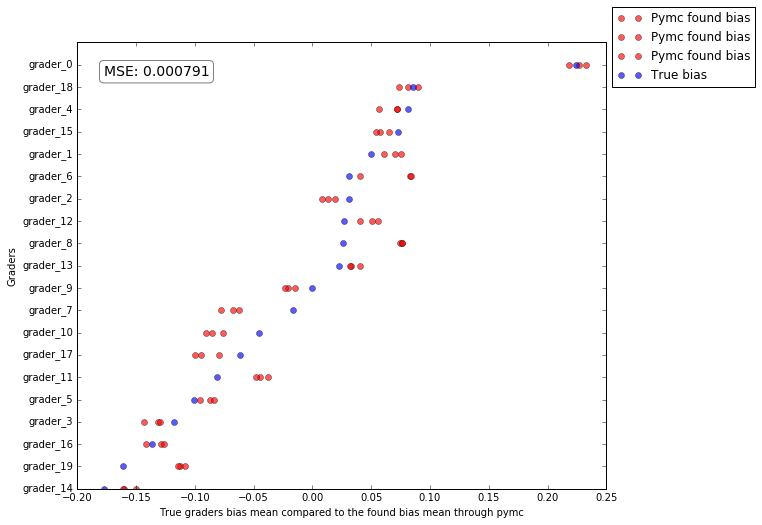

In [58]:
compare_to_generated(assignment_data_true,mcmc_1,find_bias)

0.00114590909518
0.00216690767516


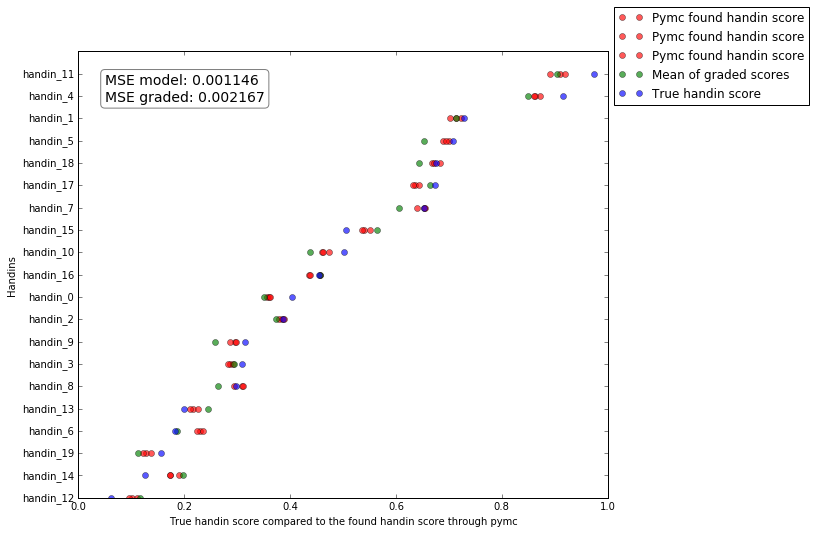

In [59]:
compare_to_generated(assignment_data_true,mcmc_1,find_T)

### MCMC_2

0.000956178087784


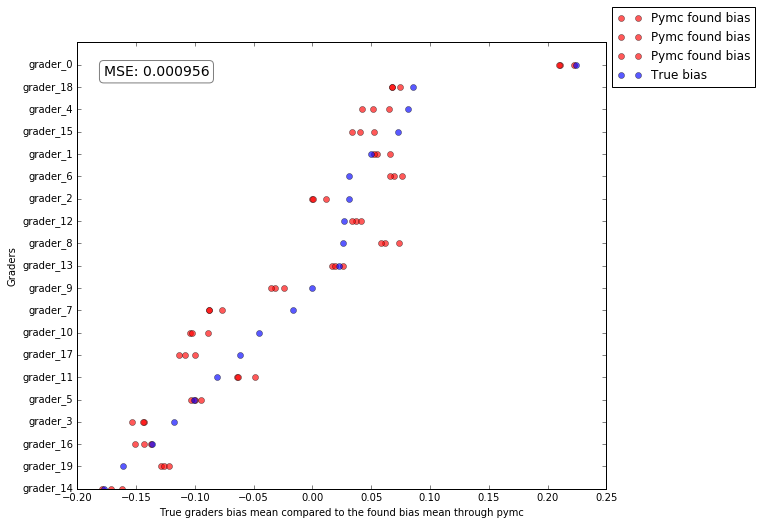

In [60]:
compare_to_generated(assignment_data_true,mcmc_2,find_bias)

0.00103863983157
0.00216690767516


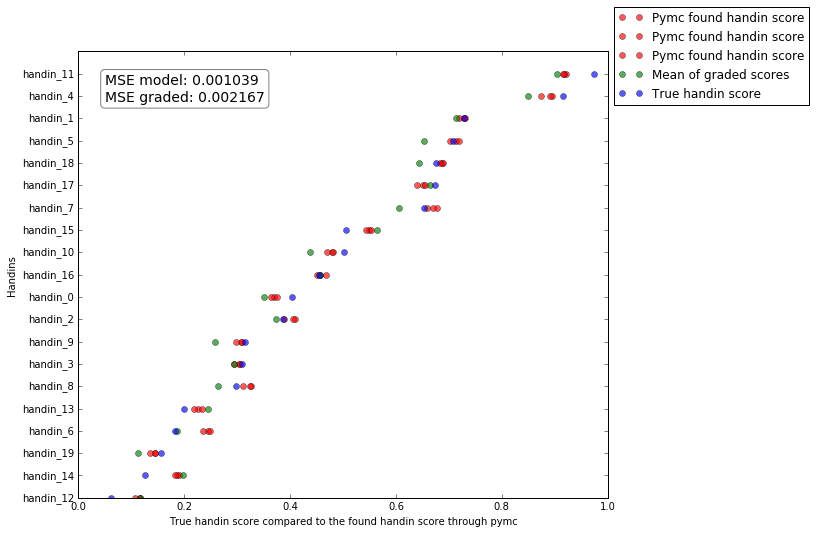

In [61]:
compare_to_generated(assignment_data_true,mcmc_2,find_T)

### MCMC_3

0.000890186826414


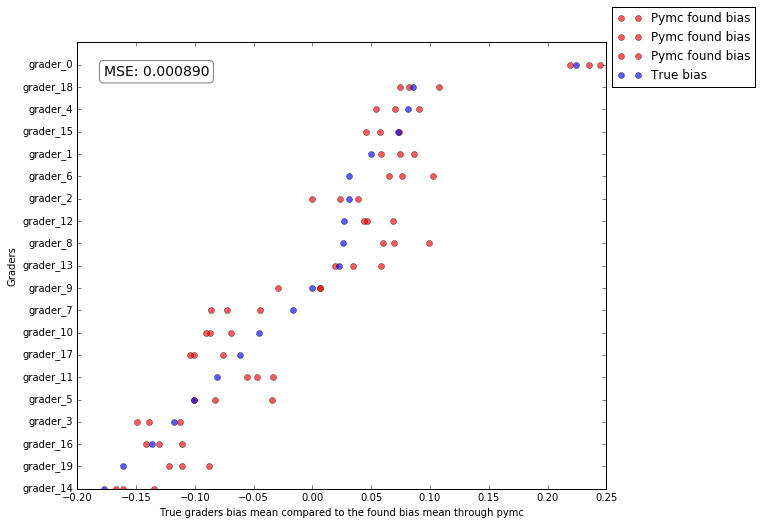

In [62]:
compare_to_generated(assignment_data_true,mcmc_3,find_bias)

0.0011604511042
0.00216690767516


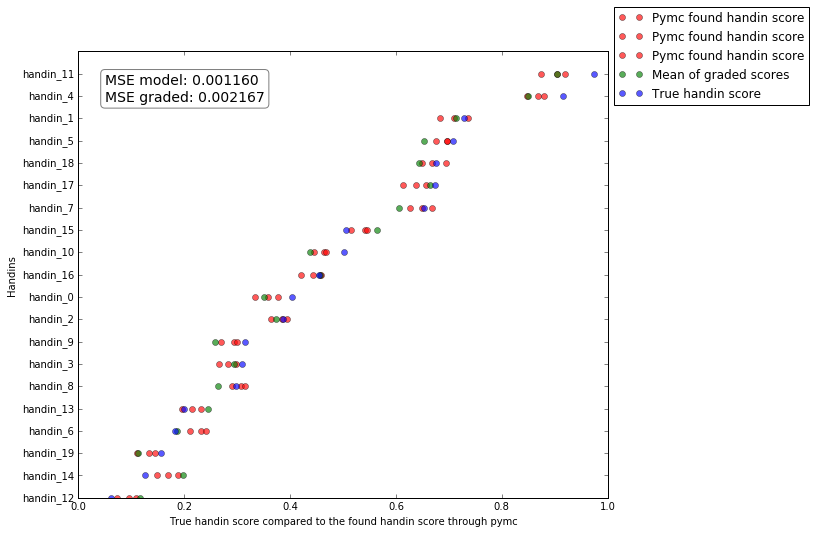

In [63]:
compare_to_generated(assignment_data_true,mcmc_3,find_T)

### MCMC_4

0.000917840125784


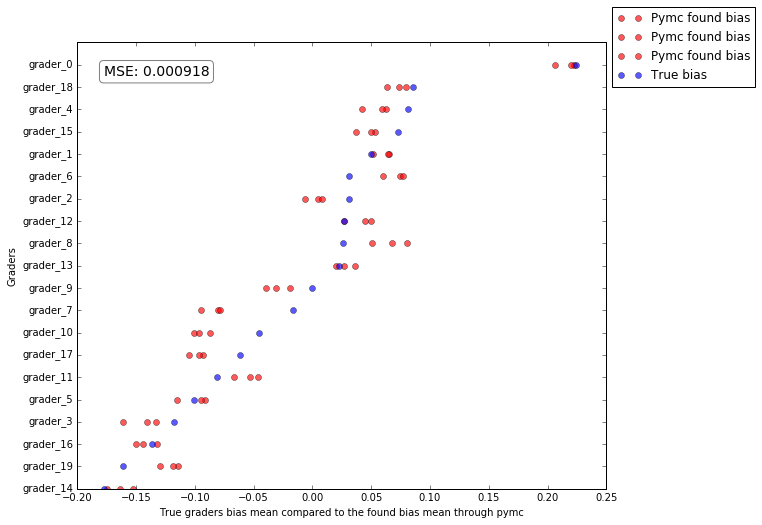

In [64]:
compare_to_generated(assignment_data_true,mcmc_4,find_bias)

0.00107320687146
0.00216690767516


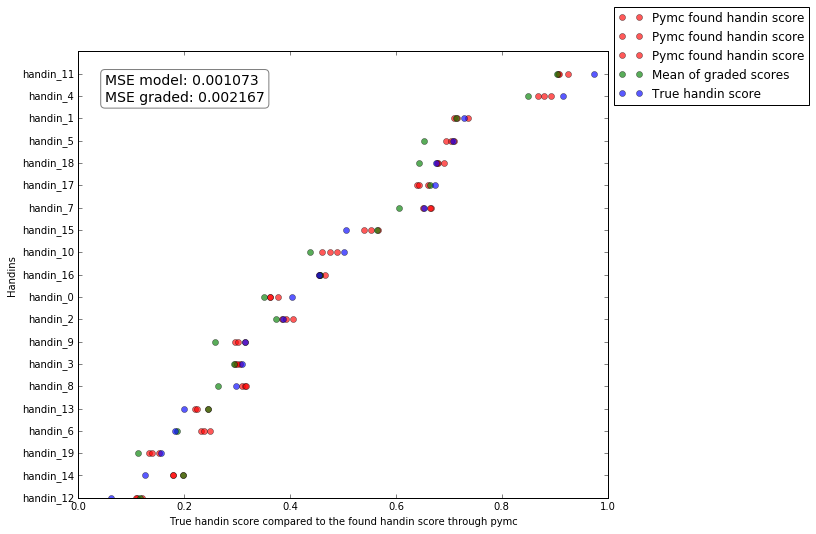

In [65]:
compare_to_generated(assignment_data_true,mcmc_4,find_T)

### MCMC_5

0.00150058858538


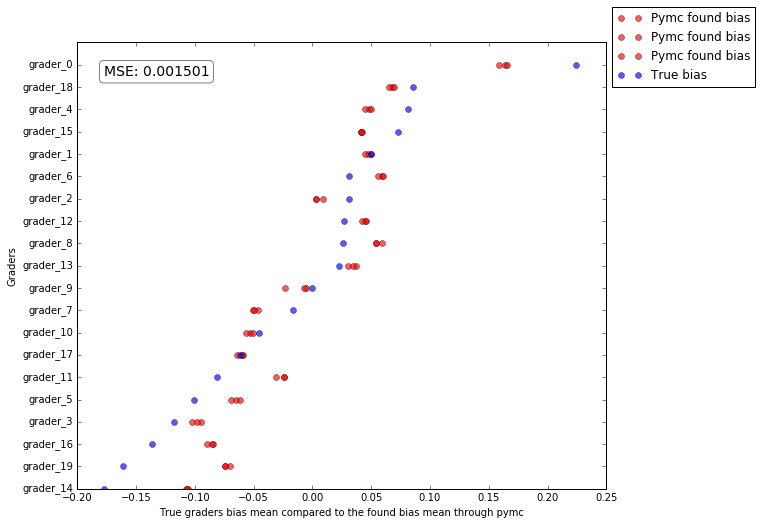

In [66]:
compare_to_generated(assignment_data_true,mcmc_5,find_bias)

0.0014553675217
0.00216690767516


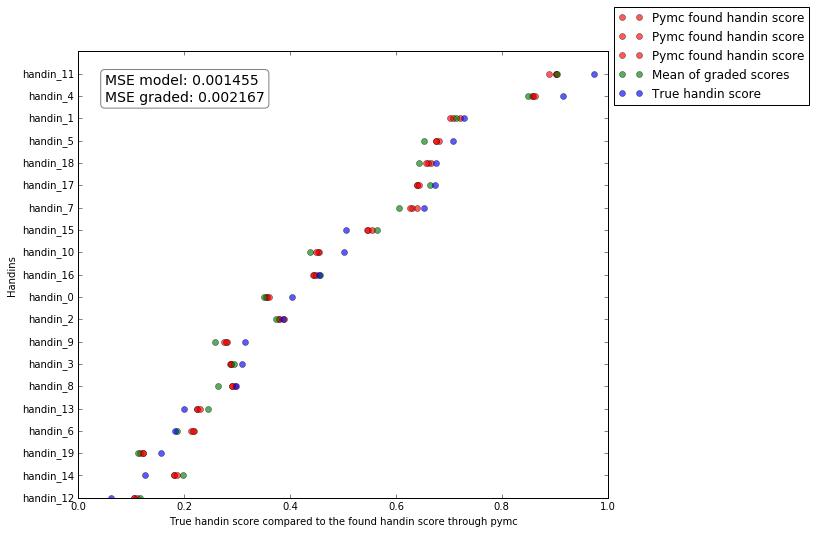

In [67]:
compare_to_generated(assignment_data_true,mcmc_5,find_T)

### MCMC_6

0.000812884738301


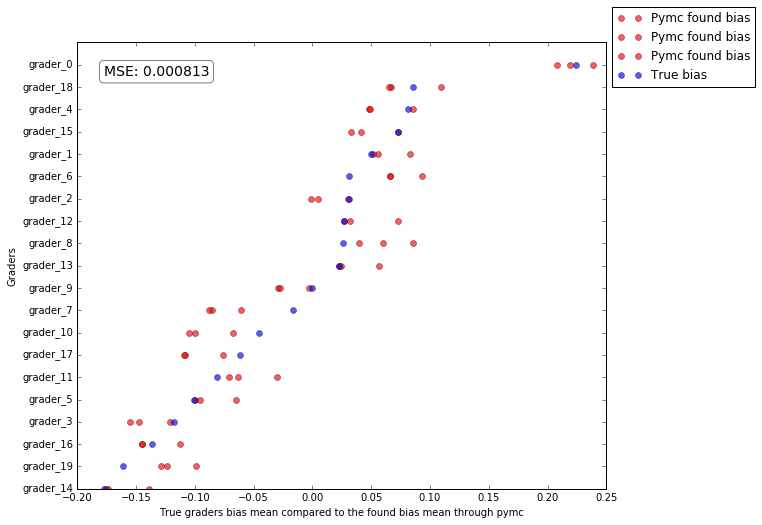

In [68]:
compare_to_generated(assignment_data_true,mcmc_6,find_bias)

0.00106466073464
0.00216690767516


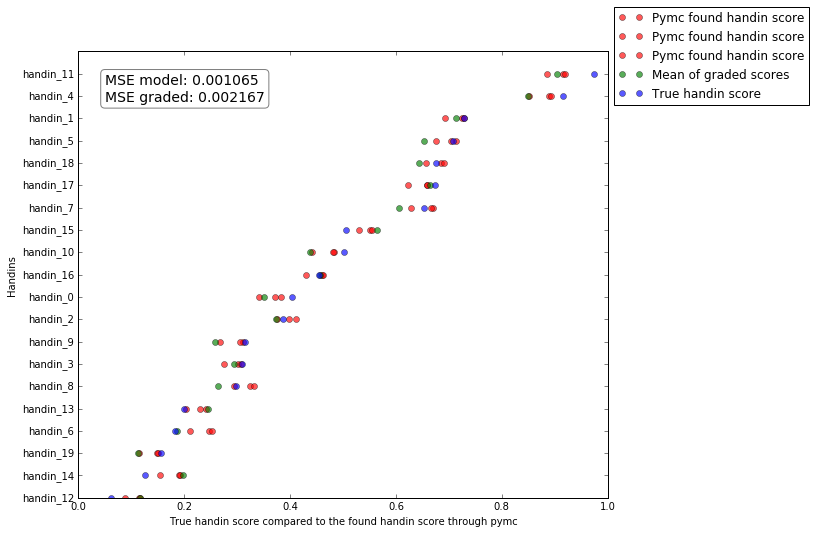

In [69]:
compare_to_generated(assignment_data_true,mcmc_6,find_T)

### Model Comparison over 5 different data set

The model have been used on 5 different generated data set and then compared against eachother to see if one model is better than the others

In [84]:
mesured_error = [[(4,0.001756),(1,0.001816),(2,0.001840),(3,0.002005),(6,0.002081),(5,0.002301)],
                 [(2,0.002043),(6,0.002046),(4,0.002279),(1,0.002351),(5,0.002987),(3,0.003079)],
                 [(6,0.001045),(3,0.001053),(4,0.001083),(1,0.001239),(2,0.001284),(5,0.003088)],
                 [(2,0.000934),(3,0.000990),(1,0.001000),(4,0.001183),(6,0.001282),(5,0.002000)],
                 [(4,0.001913),(1,0.002172),(2,0.002586),(3,0.002744),(6,0.003017),(5,0.003726)],
                 [(2,0.001213),(6,0.001242),(4,0.001312),(3,0.001362),(1,0.001644),(5,0.002533)],
                 [(1,0.000791),(6,0.000813),(3,0.000890),(4,0.000918),(2,0.000956),(5,0.001501)]]

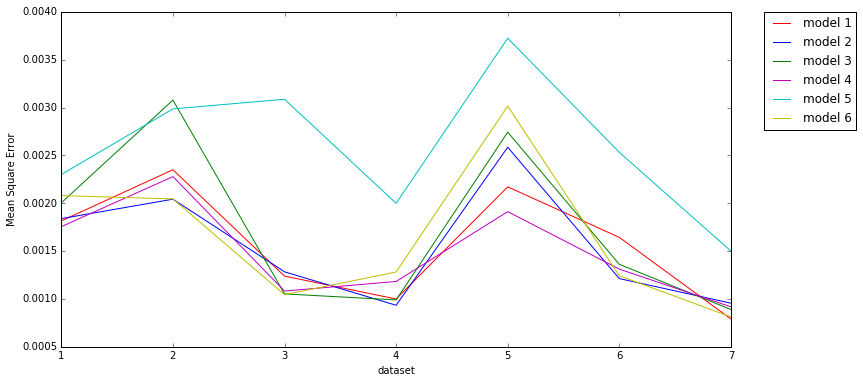

In [85]:

ax = plt.subplot(111)
colors = ['r','b','g','m','c','y']
lines = defaultdict(list)
for set_,data in enumerate(mesured_error):
    for (model,error) in data:
        lines[model].append((set_,error))
    
for model, l in lines.iteritems():
    xs = list()
    ys = list()
    for i in xrange(len(lines)+1):
        (x1,y1) = l[i]
        xs.append(x1+1)
        ys.append(y1)
    
    line = plt.plot(xs,ys,colors[model-1],label="model %i" % model)


box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width*2, box.height*1.5])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("dataset")
plt.ylabel("Mean Square Error")
plt.show()

In [80]:
pos_m = defaultdict(list)
for set_,data in enumerate(mesured_error):
    for (pos, (model,error)) in enumerate(data):
        pos_m[model].append(pos)
        
for m, pos in pos_m.iteritems():
#    print m, pos
    print "model_" + str(m) + ": mean: " + str(np.mean(pos)) + ", median: " + str(np.median(pos))

model_1: mean: 2.0, median: 2.0
model_2: mean: 1.71428571429, median: 2.0
model_3: mean: 2.57142857143, median: 3.0
model_4: mean: 1.71428571429, median: 2.0
model_5: mean: 4.85714285714, median: 5.0
model_6: mean: 2.14285714286, median: 1.0
